https://stepik.org/lesson/501479/step/1?unit=493164  
https://drive.google.com/drive/folders/15UoRIwvCOZ-6c624m5NTDfbFizOs-C0N  
https://www.kaggle.com/c/advanced-dls-spring-2021/  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

target_col = 'Churn'

In [2]:
# kaggle 0.85302

def prepare_data(data):
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = []
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG']
num_tran, cat_tran = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([('cat', cat_tran, cat_cols_), ('num', num_tran, num_cols_)])
classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=StratifiedKFold(10))
print(f'{s.mean():.4f}, {s.std():.6f}, {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8486, 0.012760, [0.85602287 0.86915698 0.85641026 0.82601263 0.84761241 0.83036046
 0.85118915 0.86194723 0.84144921 0.84548094]


In [281]:
grid = {'clf__C':[0.4,0.45,0.5,0.55,0.6], 'clf__penalty':['l1','l2']}
cv = GridSearchCV(model, grid, scoring='roc_auc', cv=StratifiedKFold(10))
cv.fit(train_data[cat_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
params['clf__C'], params['clf__penalty']

(0.5, 'l1')

In [3]:
# kaggle 0.85283

def prepare_data(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    data['TotalSpent'] = data['TotalSpent'].fillna(0)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = num_cols
cat_cols_ = cat_cols
catboost = CatBoostClassifier(learning_rate=0.16, num_trees=63)
catboost.set_params(cat_features=cat_cols_, silent=True)
s = cross_val_score(catboost, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=10)
print(f'{s.mean():.4f}, {s.var():.6f}, {s}')

catboost.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = catboost.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8480, 0.000122, [0.85309906 0.86536617 0.85293571 0.83297101 0.85815682 0.82840951
 0.84746377 0.85682832 0.84400141 0.84039504]


In [48]:
grid = {'learning_rate':[0.155,0.16,0.165], 'num_trees':[60,61,62,63,64]}
catboost = CatBoostClassifier().set_params(cat_features=cat_cols, silent=True)
cv = GridSearchCV(catboost, grid, scoring='roc_auc', cv=10)
cv.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
params['learning_rate'], params['num_trees']

(0.16, 63)

In [77]:
data = pd.read_csv('./train.csv')[num_cols]
data['TotalSpent_float'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
pd.DataFrame({'dtype': data.dtypes, 'na': data.isna().sum(), 'zero': (data == 0).sum()})

,dtype,na,zero
ClientPeriod,int64,0,9
MonthlySpending,float64,0,0
TotalSpent,object,0,0
TotalSpent_float,float64,9,0


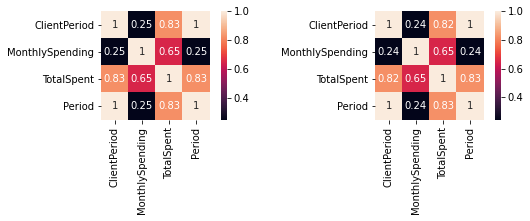

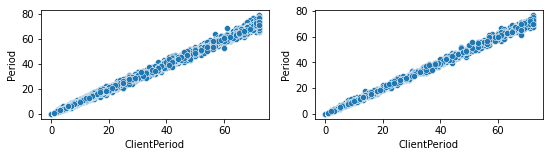

In [55]:
def prepare_data(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    data['TotalSpent'] = data['TotalSpent'].fillna(0)
    data['Period'] = data['TotalSpent'] / data['MonthlySpending']
    return data

num_cols_ = num_cols + ['Period']
train_data = prepare_data(pd.read_csv('./train.csv'))
test_data = prepare_data(pd.read_csv('./test.csv'))

fig, axes = plt.subplots(1,2,figsize=(9,2))
sns.heatmap(train_data[num_cols_].corr(method='pearson').abs(), annot=True, square=True, ax=axes[0])
sns.heatmap(test_data[num_cols_].corr(method='pearson').abs(), annot=True, square=True, ax=axes[1])

fig, axes = plt.subplots(1,2,figsize=(9,2))
sns.scatterplot(x='ClientPeriod', y='Period', data=train_data, ax=axes[0])
sns.scatterplot(x='ClientPeriod', y='Period', data=test_data, ax=axes[1]);

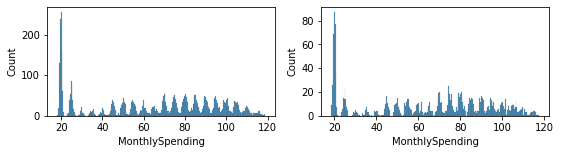

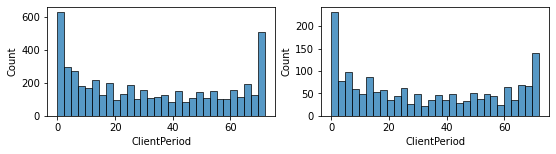

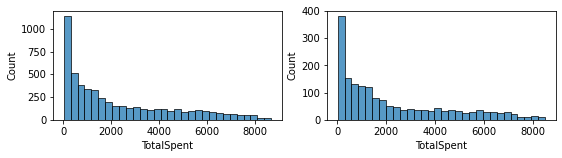

In [104]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

train_data['TotalSpent'] = pd.to_numeric(train_data['TotalSpent'], errors='coerce')
test_data['TotalSpent'] = pd.to_numeric(test_data['TotalSpent'], errors='coerce')

# multimodal normal distribution
fig, axes = plt.subplots(1,2,figsize=(9,2))
sns.histplot(train_data['MonthlySpending'], bins=250, ax=axes[0])
sns.histplot(test_data['MonthlySpending'], bins=250, ax=axes[1])

fig, axes = plt.subplots(1,2,figsize=(9,2))
sns.histplot(train_data['ClientPeriod'], bins=30, ax=axes[0])
sns.histplot(test_data['ClientPeriod'], bins=30, ax=axes[1])

fig, axes = plt.subplots(1,2,figsize=(9,2))
sns.histplot(train_data['TotalSpent'], bins=30, ax=axes[0])
sns.histplot(test_data['TotalSpent'], bins=30, ax=axes[1]);

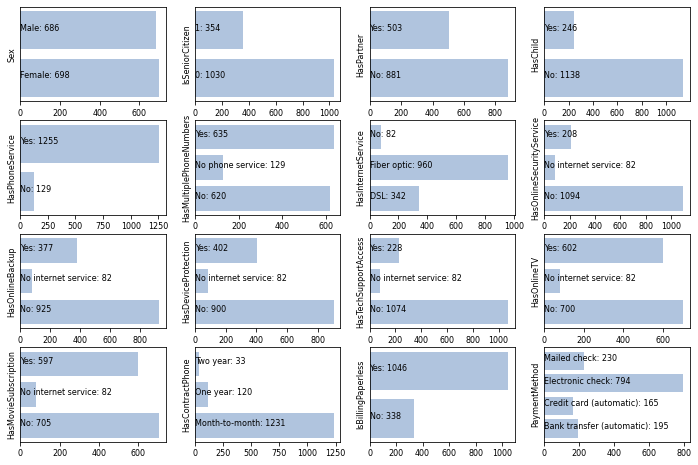

In [68]:
train_data = pd.read_csv('./train.csv')
fig, axes = plt.subplots(4, 4, figsize=(12,8))
for c, ax in zip(cat_cols, axes.flat):
    cnt = train_data.groupby(c)['Churn'].sum()
    ax.barh(cnt.index, cnt.values, color='lightsteelblue')
    ax.tick_params(axis='x', labelsize=8)
    ax.set_ylabel(c, fontsize=8)
    ax.set_yticks([])
    z = zip(range(len(cnt)), cnt.index, cnt.values)
    for i, k, v in z: ax.text(0, i, f'{k}: {v}', fontsize=8)

In [13]:
def prepare_data(data):
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = []
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG']
num_tran, cat_tran = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([('cat', cat_tran, cat_cols_), ('num', num_tran, num_cols_)])
classifier = RandomForestClassifier(n_estimators=200, max_depth=6, criterion='entropy')
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=StratifiedKFold(10))
print(f'{s.mean():.4f}, {s.std():.6f}, {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8381, 0.015953, [0.8340712  0.86145545 0.83272018 0.81193794 0.84512263 0.81465998
 0.8460052  0.86263471 0.83595643 0.8366962 ]


In [12]:
grid = {'clf__n_estimators':[100,200],'clf__max_depth':[5,6,7]}
cv = GridSearchCV(model, grid, scoring='roc_auc', cv=StratifiedKFold(10))
cv.fit(train_data[cat_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
params['clf__n_estimators'], params['clf__max_depth']

(200, 6)

In [325]:
def prepare_data(data):
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = []
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG']
num_tran, cat_tran = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([('cat', cat_tran, cat_cols_), ('num', num_tran, num_cols_)])
classifier = KNeighborsClassifier(n_neighbors=90, leaf_size=1, p=1)
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=StratifiedKFold(10))
print(f'{s.mean():.4f}, {s.std():.6f}, {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8281, 0.017077, [0.82629589 0.8469655  0.82209216 0.80027871 0.83951133 0.80282423
 0.83045336 0.85909513 0.82828133 0.82470271]


In [294]:
grid = {'clf__n_neighbors':range(50,100,5), 'clf__leaf_size':range(1,50,5), 'clf__p':[1,2]}
cv = GridSearchCV(model, grid, scoring='roc_auc', cv=StratifiedKFold(10))
cv.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
params['clf__n_neighbors'], params['clf__leaf_size'], params['clf__p']

(90, 1)

In [8]:
# data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
# data['TotalSpent'] = data['TotalSpent'].fillna(0)

# data['ClientPeriodLog'] = np.log1p(data['ClientPeriod'])
# data['MonthlySpendingLog'] = np.log1p(data['MonthlySpending'])
# data['TotalSpentLog'] = np.log1p(data['TotalSpent'])
# data['TotalSpentCox'] = stats.boxcox(data['TotalSpent'])[0]

In [240]:
data = pd.read_csv('./test.csv')
data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,24,33,43,53,62,70,72,100]).astype(str)
# data.groupby('ClientPeriodG')['Churn'].size()
# data[data['ClientPeriod'] == 0]['ClientPeriodG']
# data.groupby('ClientPeriodG')['Churn'].mean()
# cats, bins = pd.qcut(data['ClientPeriod'], 11, retbins=True)

<AxesSubplot:>

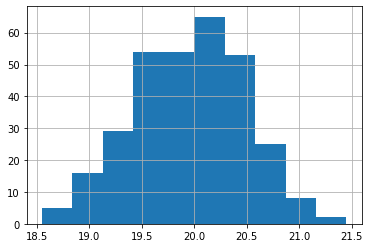

In [229]:
data[data['MonthlySpending'].between(17.5,22.5)]['MonthlySpending'].hist()

In [221]:
data[data['MonthlySpending'].between(22.5, 27.5)]['Churn'].mean()

0.10778443113772455

In [9]:
data = pd.read_csv('./train.csv')
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

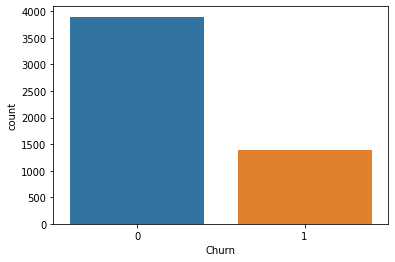

In [192]:
sns.countplot(x=target_col, data=data);

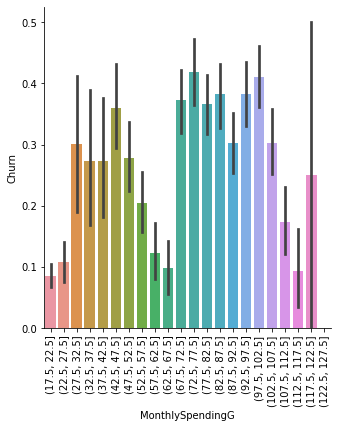

In [31]:
data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,130,5))
g = sns.catplot(x="MonthlySpendingG", y="Churn", data=data, kind="bar");
g.set_xticklabels(rotation=90);

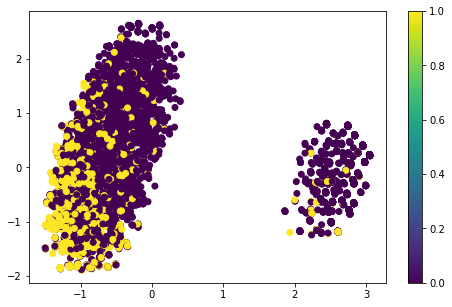

In [494]:
from sklearn.decomposition import PCA
data = pd.read_csv('./train.csv')
X, y = data[cat_cols], data[target_col]
X = pd.get_dummies(X, columns=cat_cols)
X2 = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(8,5))
plt.scatter(X2[:,0], X2[:,1], c=y)
plt.colorbar();

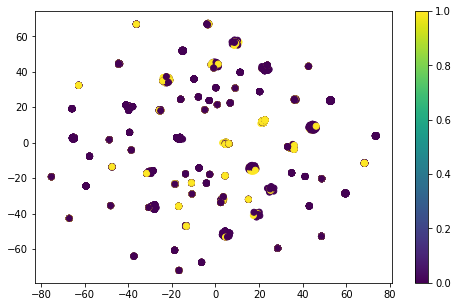

In [526]:
cols = ['HasTechSupportAccess','HasDeviceProtection','IsBillingPaperless','HasOnlineTV','PaymentMethod']

from sklearn.manifold import TSNE
data = pd.read_csv('./train.csv')
X, y = data[cols], data[target_col]
X = pd.get_dummies(X)
X2 = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(8,5))
plt.scatter(X2[:,0], X2[:,1], c=y)
plt.colorbar();

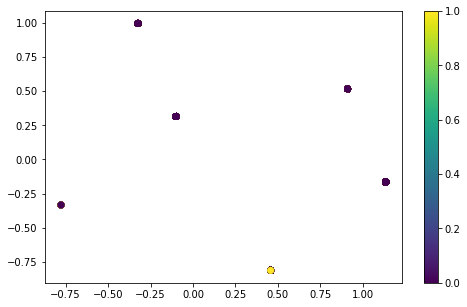

In [536]:
cols = ['HasTechSupportAccess','IsBillingPaperless']

from sklearn.decomposition import PCA
data = pd.read_csv('./train.csv')
X, y = data[cols], data[target_col]
X = pd.get_dummies(X)
X2 = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(8,5))
plt.scatter(X2[:,0], X2[:,1], c=y)
plt.colorbar();